In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.storms import Extract_Circle_Nakajo, GetCategoryChangeProbs
from teslakit.plotting.storms import Plot_Category_Change



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

xds_Nakajo = db.Load_TCs_Nakajo()  # Nakajo simulations

# wave point longitude and latitude
pnt_lon = 167.5
pnt_lat = 9.75

# radius for TCs selection (º)
r1 = 14
r2 = 4



## Synthetic TCs - Category Change Probabilities

In [4]:
# --------------------------------------
# Select Nakajo TCs inside circle

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'pressure':'yCPRES',
}

# Extract TCs inside R=14 and positions
_, xds_in_r1 = Extract_Circle_Nakajo(xds_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

# Extract TCs inside R=4 and positions
_, xds_in_r2 = Extract_Circle_Nakajo(xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)

print(xds_in_r1)
print()
print(xds_in_r2)


<xarray.Dataset>
Dimensions:       (storm: 63167)
Coordinates:
  * storm         (storm) int64 5 8 14 50 52 ... 999974 999982 999986 999990
Data variables:
    pressure_min  (storm) float64 983.2 932.8 960.5 978.9 ... 968.4 973.3 992.4
    category      (storm) int64 1 4 3 2 1 0 0 0 2 1 5 ... 0 4 1 2 1 1 4 0 2 2 1
Attributes:
    point_lon:  167.5
    point_lat:  9.75
    point_r:    14

<xarray.Dataset>
Dimensions:       (storm: 12840)
Coordinates:
  * storm         (storm) int64 5 296 299 387 ... 999846 999877 999982 999986
Data variables:
    pressure_min  (storm) float64 988.1 961.0 998.7 ... 976.4 1.007e+03 998.5
    category      (storm) int64 1 3 1 1 2 4 0 2 0 0 1 ... 3 1 2 3 2 1 1 0 2 0 1
Attributes:
    point_lon:  167.5
    point_lat:  9.75
    point_r:    4


In [5]:
# --------------------------------------
# Calculate Syntethic TCs category change probabilities

xds_categ_cp = GetCategoryChangeProbs(xds_in_r1, xds_in_r2)
print(xds_categ_cp)

db.Save_TCs_probs_synth(xds_categ_cp)


<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_count    (category, category) int64 1811 1299 264 ... 0 990
    category_change_sum      (category) int64 20195 18556 3722 4182 1854 1818
    category_change_probs    (category, category) float64 0.0823 ... 0.2465
    category_nochange_probs  (category) float64 0.9177 0.8788 ... 0.4346 0.4527
    category_change_cumsum   (category, category) float64 0.0823 ... 0.5473


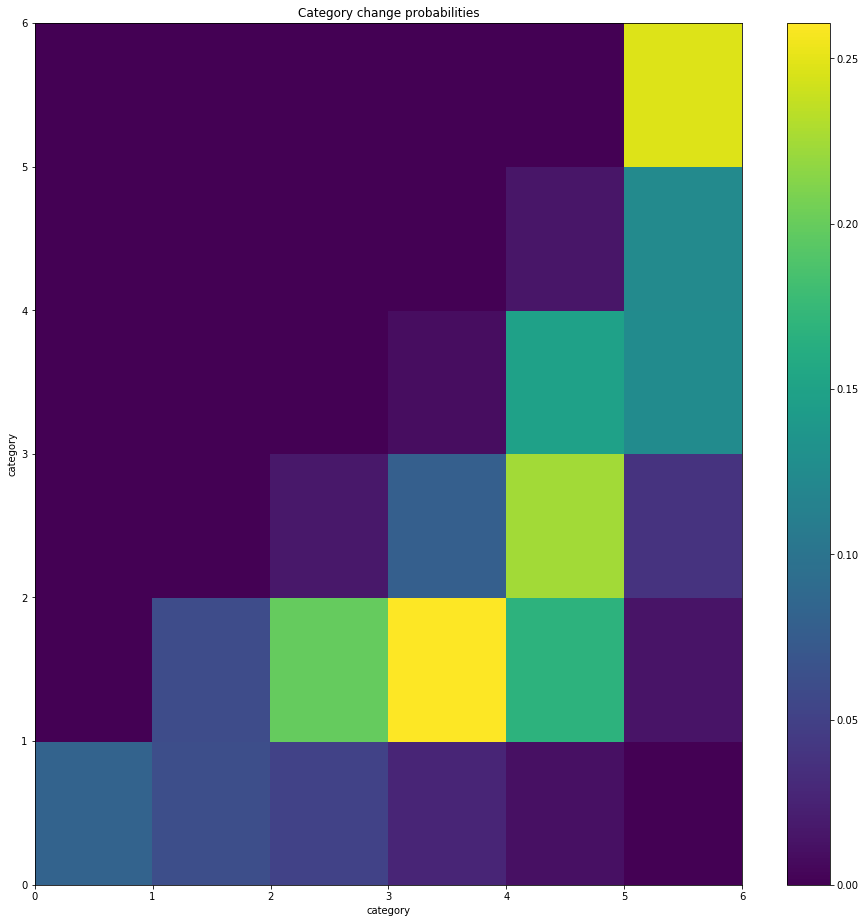

In [6]:
# plot category change probabilities

Plot_Category_Change(xds_categ_cp)
